In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

In [3]:
def load_annotations(path: str) -> pd.DataFrame:
    """
    Loads a csv-like annotation file with fields ["frame", "ID", "left", "top",
    "width", "height", "confidence", "null1", "null2", "null3"] into a pandas
    dataframe. Check Nvidia AICity challenge readme for further detail.

    Parameters
    ----------
    path: str
        Path string for the input file.

    Returns
    -------
    pd.DataFrame
        Pandas dataframe which contains the loaded csv with only the needed
        columns ["frame", "ID", "left", "top", "width", "height", "confidence"].
    """
    ann = pd.read_csv(
        path,
        sep=",",
        names=["frame", "ID", "left", "top", "width", "height", "confidence",
               "null1", "null2", "null3"]
    )
    ann = ann[["frame", "ID", "left", "top", "width", "height", "confidence"]]
    return ann


In [4]:
def vectorise_annotations(df: pd.DataFrame) -> np.ndarray:
    """
    From a pandas dataframe with the bounding boxes of a single class and a
    single frame, produce a confidence-ordered array of boxes in xyxy format.
    The input dataframe should have the same row indices as load_annotations.

    Parameters
    ----------
    df: pd.DataFrame
        Pandas dataframe with the same format as produced by the function
        load_annotations.

    Returns
    -------
    ArrayLike
        Array of shape Nx4 where N is the number of boxes and each component
        is a xyxy format bounding box (left, top, right, bottom coordinates).

    See Also
    --------
    load_annotations : load_annotations function.
    """
    df.sort_values("confidence")
    xyxy_format = (
        df["left"],
        df["top"],
        df["left"] + df["width"],
        df["top"] + df["height"],
    )
    return np.asarray(xyxy_format).T

In [5]:
def iou(
        gt: np.ndarray,
        pred: np.ndarray
) -> np.ndarray:
    """
    Returns the Intersection over Union of a given set of "pred" grid-aligned
    rectangles against a set of reference "gt" grid-aligned rectangles.

    Parameters
    ----------
    gt : ArrayLike
        Set of grid-aligned rectangles to compare against. Provided as a Nx4
        matrix of N points of (x1, y1, x2, y2) coordinates.
    pred : ArrayLike
        Set of grid-aligned rectangles to be compared. Provided as a Mx4
        matrix of M points of (x1, y1, x2, y2) coordinates.

    Returns
    -------
    ArrayLike:
        A NxM matrix with the IoU of each cmp rectangle against each reference
        rectangle.
    """
    n, m = gt.shape[0], pred.shape[0]
    s_gt = np.stack([gt] * m, axis=1)
    s_pred = np.stack([pred] * n, axis=0)

    # Intersection
    intr_x = np.min(np.stack((s_gt[:, :, 2], s_pred[:, :, 2]), axis=0), axis=0) - \
             np.max(np.stack((s_gt[:, :, 0], s_pred[:, :, 0]), axis=0), axis=0)
    intr_x = np.maximum(intr_x, 0)

    intr_y = np.min(np.stack((s_gt[:, :, 3], s_pred[:, :, 3]), axis=0), axis=0) - \
             np.max(np.stack((s_gt[:, :, 1], s_pred[:, :, 1]), axis=0), axis=0)
    intr_y = np.maximum(intr_y, 0)

    intr_t = intr_x * intr_y

    # Union
    area_r = (s_gt[:, :, 2] - s_gt[:, :, 0]) * (s_gt[:, :, 3] - s_gt[:, :, 1])
    area_c = (s_pred[:, :, 2] - s_pred[:, :, 0]) * (s_pred[:, :, 3] - s_pred[:, :, 1])

    union = area_r + area_c - intr_t

    return intr_t / union

In [106]:
def select_bboxes(inter: np.ndarray, thresh: float) -> np.ndarray:
    """
    From the output of IoU (an NxM matrix where N is the number of ground truth
    samples and M is the number of predictions and the value it contains is the
    Intersection Over Union between the n-th and m-th box), generates the chosen
    predicted bounding boxes assuming they are above a set threshold.

    Parameters
    ----------
    inter: np.ndarray
        NxM matrix where N is the number of ground truth
        samples and M is the number of predictions and the value it contains is the
        intersection-over-union between the n-th and m-th box.
    thresh: float
        Acceptance value for Intersection over Union.

    Returns
    -------
    np.ndarray
        M-length array with the selected GT box at each prediction. If a
        prediction box has no corresponding gt, -1 is returned accordingly.
    """
    n, m = inter.shape
    ind_max = np.full(m, -1)

    for ii in range(m):
        above = inter[:, ii] >= thresh
        if np.any(above):
            ind_max[ii] = np.argmax(inter[:, ii])
            inter[ind_max[ii],:] = 0.0

    return ind_max

In [169]:
def average_precision_frame(
        gt: np.ndarray,
        pred: np.ndarray,
        thresh: float
) -> float:
    """
    Computes the average precision for a single frame and class. The input is
    assumed to be filtered accordingly.

    Parameters
    ----------
    gt: ArrayLike
        Array of shape Nx4 where N is the number of boxes and each component
        is a xyxy format bounding box (left, top, right, bottom coordinates).
        These represent the ground truth boxes.
    pred: ArrayLike
        Array of shape Nx4 where N is the number of boxes and each component
        is a xyxy format bounding box (left, top, right, bottom coordinates).
        These represent a predictions' boxes.
    thresh: float
        Intersection-over-union threshold. Whenever the area is below this
        threshold, the prediction is ignored.

    Returns
    -------
    float
        Average precision for the given bounding boxes.
    """
    inter = iou(gt, pred)
    n, m = inter.shape
    ind_max = select_bboxes(inter, thresh)

    tp_evol = np.cumsum(ind_max >= 0)
    pre = tp_evol / np.arange(1, m + 1)
    rec = tp_evol / gt.shape[0]

    curr_max = -1
    out_pre = np.zeros_like(pre)

    for ii in range(len(pre)):
        curr_max = max(pre[len(pre) - ii - 1], curr_max)
        out_pre[len(pre) - ii - 1] = curr_max

    sampling_points = np.arange(0.0, 1.01, 0.1)
    pre_ind = rec[None,:] >= sampling_points[:, None]
    pre_ind = np.where(np.any(pre_ind, axis=1), np.argmax(pre_ind, axis=1), -1)

    ap = sum(np.where(pre_ind >= 0, out_pre[pre_ind], 0.0)) / 11

    return ap

In [31]:
def draw_boxes(
        frame: np.ndarray,
        gt_coords: np.ndarray,
        pd_coords: np.ndarray,
        out_path:str=None
) -> None:
    """
    Produces a representation of a single frame with the provided ground truth
    and predicted bounding boxes drawn accordingly. If an out_path is provided
    then the output is not shown as a floating plot, being saved instead into
    the specified file instead.

    Parameters
    ----------
    frame: ArrayLike
        Image in RGB format to draw.
    gt_coords: ArrayLike
        Array of shape Nx4 where N is the number of boxes and each component
        is a xyxy format bounding box (left, top, right, bottom coordinates).
        These represent the ground truth boxes.
    pd_coords: ArrayLike
        Array of shape Nx4 where N is the number of boxes and each component
        is a xyxy format bounding box (left, top, right, bottom coordinates).
        These represent the ground truth boxes.
    out_path: str
        Full filename and path of an output image to save the results.

    Returns
    -------
    None
    """
    plt.figure()
    plt.imshow(frame)
    plt.axis("off")

    for ii in range(gt_coords.shape[0]):
        plt.gca().add_patch(
            patches.Rectangle(
                (gt_coords[ii, 0], gt_coords[ii, 1]),
                gt_coords[ii, 2] - gt_coords[ii, 0],
                gt_coords[ii, 3] - gt_coords[ii, 1],
                color="g",
                alpha=0.3,
        ))
    for ii in range(pd_coords.shape[0]):
        plt.gca().add_patch(
            patches.Rectangle(
                (pd_coords[ii, 0], pd_coords[ii, 1]),
                pd_coords[ii, 2] - pd_coords[ii, 0],
                pd_coords[ii, 3] - pd_coords[ii, 1],
                color="r",
                alpha=0.3,
            ))
    if out_path is not None:
        plt.savefig(out_path)
    else:
        plt.show()
    plt.close()

In [156]:
def compute_avg_precision(
        gt_path: str,
        pd_path: str,
        iou_thresh: float,
        alter_prediction: callable = None,
        add_params: dict = None,
) -> dict:
    """
    Computes the average precision from a prediction file w.r.t. a ground truth
    file. Both cases should respect the csv-like annotation format from Nvidia
    AICity challenge.

    Parameters
    ----------
    gt_path: str
        Path to the ground truth file.
    pd_path: str
        Path to the prediction file.
    iou_thresh: float
        IoU threshold above which a prediction is considered correct.
    alter_prediction: callable
        Function to modify the prediction (to test stochastic modifications
        for instance).
    add_params: dict
        Extra parameters for the alter_prediction function.

    Returns
    -------
    dict
        A dictionary containing each frame as key and the computed average
        precision as value.

    See Also
    --------
    load_annotations : load_annotations function.
    """
    truth = load_annotations(gt_path)
    pred = load_annotations(pd_path)

    if alter_prediction is not None:
        pred = alter_prediction(pred, **add_params)

    frame_indices = pd.unique(truth["frame"])
    output = {}

    for frame_id in frame_indices:
        gt_frame = vectorise_annotations(truth[truth["frame"] == frame_id])
        pd_frame = vectorise_annotations(pred[pred["frame"] == frame_id])

        if pd_frame.shape[0] == 0:
            output[frame_id] = 0.0
        else:
            output[frame_id] = average_precision_frame(gt_frame, pd_frame, iou_thresh)

    return output


In [10]:
def generate_gt_from_xml(in_path: str, out_path: str) -> None:
    dataset = ET.parse(in_path).getroot()

    # Separate annotations by frames. We do not care about the classes for the time
    # being, we only grab cars

    annotations = []

    # [frame, ID, left, top, width, height, 1, -1, -1, -1]
    for track in dataset.findall("track"):
        if track.attrib["label"] == "car":
            for box in track.findall("box"):
                annot = (
                    box.attrib["frame"], track.attrib["id"],
                    box.attrib["xtl"], box.attrib["ytl"],
                    float(box.attrib["xbr"]) - float(box.attrib["xtl"]),
                    float(box.attrib["ybr"]) - float(box.attrib["ytl"]),
                    1, -1, -1, -1
                )

                # Some functional magic to convert all elements in the tuple to
                # strings of integer numbers
                annot = tuple(map(lambda x: str(int(float(x))), annot))
                annotations.append(annot)

    with open(out_path, 'w') as f_gt:
        for ii in annotations:
            f_gt.write(",".join(ii) + "\n")

In [11]:
def dropout_predictions(pred: pd.DataFrame, prob: float) -> pd.DataFrame:
    decision = np.random.rand(len(pred)) > prob
    pred = pred[decision]
    return pred

In [12]:
def offset_predictions(pred: pd.DataFrame, offset: int) -> pd.DataFrame:
    pred[["left", "top"]] = pred[["left", "top"]] + offset
    return pred

In [13]:
def iou_offset(gt: np.ndarray, offset: int) -> float:
    width = gt[:,2] - gt[:,0]
    height = gt[:,3] - gt[:,1]

    intersect = (width - offset) * (height - offset)
    union = (2 * width * height) - intersect

    return intersect / union

In [152]:
def test_iou(
        gt_path: str,
        offset: int
    ) -> float:

    truth = load_annotations(gt_path)

    frame_indices = pd.unique(truth["frame"])
    correct = 0
    total = 0

    for frame_id in frame_indices:
        gt_frame = vectorise_annotations(truth[truth["frame"] == frame_id])
        iou_normal = np.max(iou(gt_frame, gt_frame + offset), axis=1)
        iou_theory = iou_offset(gt_frame, offset)

        if np.any(np.not_equal(iou_normal, iou_theory)):
            print(frame_id, iou_theory, iou_normal)
            img = mpimg.imread(f"/home/pau/Documents/master/M6/project/data/"
                               f"AICity_data/AICity_data/train/S03/c010/"
                               f"vdo_frames/{frame_id:05}.jpg")
            draw_boxes(img, gt_frame, gt_frame + offset)

        correct += np.count_nonzero(iou_normal == iou_theory)
        total += np.prod(iou_normal.shape)

    return correct / total

In [153]:
ANNOTATION_PATH = "/home/pau/Documents/master/M6/project/data/ai_challenge_s03_c010-full_annotation.xml"
VIDEO_PATH = "/home/pau/Documents/master/M6/project/data/AICity_data/AICity_data/train/S03/c010/vdo_frames"
GT_PATH = "/home/pau/Documents/master/M6/project/data/AICity_data/AICity_data/train/S03/c010/gt/gt.txt"
GT_FANCY_PATH = "/home/pau/Documents/master/M6/project/data/AICity_data/AICity_data/train/S03/c010/gt/gt_challenge.txt"
OUT_PATH = "/home/pau/Documents/master/M6/project/data/AICity_data/AICity_data/train/S03/c010/vdo_gt_yolo"

DET_RCNN_PATH = "/home/pau/Documents/master/M6/project/data/AICity_data/AICity_data/train/S03/c010/det/det_mask_rcnn.txt"
DET_SSD_PATH = "/home/pau/Documents/master/M6/project/data/AICity_data/AICity_data/train/S03/c010/det/det_ssd512.txt"
DET_YOLO_PATH = "/home/pau/Documents/master/M6/project/data/AICity_data/AICity_data/train/S03/c010/det/det_yolo3.txt"

In [154]:
gt = load_annotations(GT_PATH)
gt_fancy = load_annotations(GT_FANCY_PATH)
det_yolo = load_annotations(DET_YOLO_PATH)
det_ssd = load_annotations(DET_SSD_PATH)
det_rcnn = load_annotations(DET_RCNN_PATH)

In [155]:
def mean_average_precision(frame_predictions: dict) -> float:
    total_ap = 0.0
    total_pred = 0.0
    for _, ap in frame_predictions.items():
        total_ap += ap
        total_pred += 1
    return total_ap / total_pred

In [ ]:
test_iou(GT_PATH, 25)

In [ ]:
test_iou(GT_PATH, 50)

In [ ]:
compute_avg_precision(GT_PATH, GT_PATH, 0.5)

In [ ]:
compute_avg_precision(GT_PATH, GT_PATH, 0.5, dropout_predictions, {"prob": 0.5})

In [130]:
mean_average_precision(
    compute_avg_precision(
        GT_PATH,
        GT_PATH,
        0.5,
        offset_predictions,
        {"offset": 25}
    )
)

0.8024720305486701

In [131]:
mean_average_precision(
    compute_avg_precision(
        GT_PATH,
        GT_PATH,
        0.5,
        offset_predictions,
        {"offset": 50}
    )
)

0.2582903463522476

In [172]:
mean_average_precision(compute_avg_precision(GT_PATH, GT_PATH, 0.5))

1.0

## A note on naming

```GT_FANCY_PATH``` refers to the fine-grained annotation in the xml file. The
regular txt GT is ```GT_PATH```.

In [182]:
rcnn_dict = compute_avg_precision(GT_PATH, DET_RCNN_PATH, 0.5)
mean_average_precision(rcnn_dict)

0.3347400783189259

In [183]:
ssd_dict = compute_avg_precision(GT_PATH, DET_SSD_PATH, 0.5)
mean_average_precision(ssd_dict)

0.4607840697744926

In [184]:
yolo_dict = compute_avg_precision(GT_PATH, DET_YOLO_PATH, 0.5)
mean_average_precision(yolo_dict)

0.6131383845827473

## Fancy here

In [179]:
rcnn_dict = compute_avg_precision(GT_FANCY_PATH, DET_RCNN_PATH, 0.5)
mean_average_precision(rcnn_dict)

0.37069293079859433

In [180]:
ssd_dict = compute_avg_precision(GT_FANCY_PATH, DET_SSD_PATH, 0.5)
mean_average_precision(ssd_dict)

0.3781449309940665

In [181]:
yolo_dict = compute_avg_precision(GT_FANCY_PATH, DET_YOLO_PATH, 0.5)
mean_average_precision(yolo_dict)

0.43617834109427417

In [81]:
def iou_time(
        groundtruth: pd.DataFrame,
        pred: pd.DataFrame,
        img_path: str=None,
        out_path: str=None
):
    frame_indices = pd.unique(groundtruth["frame"])
    iou_values = np.zeros_like(frame_indices, dtype=float)
    iou_values_nonzero = np.zeros_like(frame_indices, dtype=float)

    for ii, frame in enumerate(frame_indices):
        gt_frame = vectorise_annotations(groundtruth[gt_fancy["frame"] == frame])
        pd_frame = vectorise_annotations(pred[pred["frame"] == frame])
        if pd_frame.shape[0] and gt_frame.shape[0]:
            intouni = iou(gt_frame, pd_frame)
            boxes = select_bboxes(intouni, 0.5)
            values = np.where(boxes >= 0, np.max(intouni, axis=1), 0.0)
            if out_path is not None:
                img = mpimg.imread(img_path + f"/{frame + 1:05}.jpg")
                draw_boxes(img, gt_frame, pd_frame, out_path + f"/{frame:05}.jpg")
            iou_values[ii] = np.mean(values)
            iou_values_nonzero[ii] = np.mean(values[values > 0.0])
        else:
            print(frame)
    return iou_values, iou_values_nonzero

In [29]:
from pathlib import Path

OUT_PATH = Path("/home/pau/Documents/master/M6/project/data/AICity_data/"
                "AICity_data/train/S03/c010")

YOLO_OUT_PATH = OUT_PATH / "vdo_gtfancy_yolo"
YOLO_OUT_PATH.mkdir(parents=True, exist_ok=True)
SSD_OUT_PATH = OUT_PATH / "vdo_gtfancy_ssd"
SSD_OUT_PATH.mkdir(parents=True, exist_ok=True)
MASK_OUT_PATH = OUT_PATH / "vdo_gtfancy_mask"
MASK_OUT_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
yolo_iou, yolo_iou_nz = iou_time(
    gt_fancy,
    det_yolo,
)

In [ ]:
ssd_iou, ssd_iou_nz = iou_time(
    gt_fancy,
    det_ssd,
)

In [ ]:
mask_iou, mask_iou_nz = iou_time(
    gt_fancy,
    det_rcnn,
)

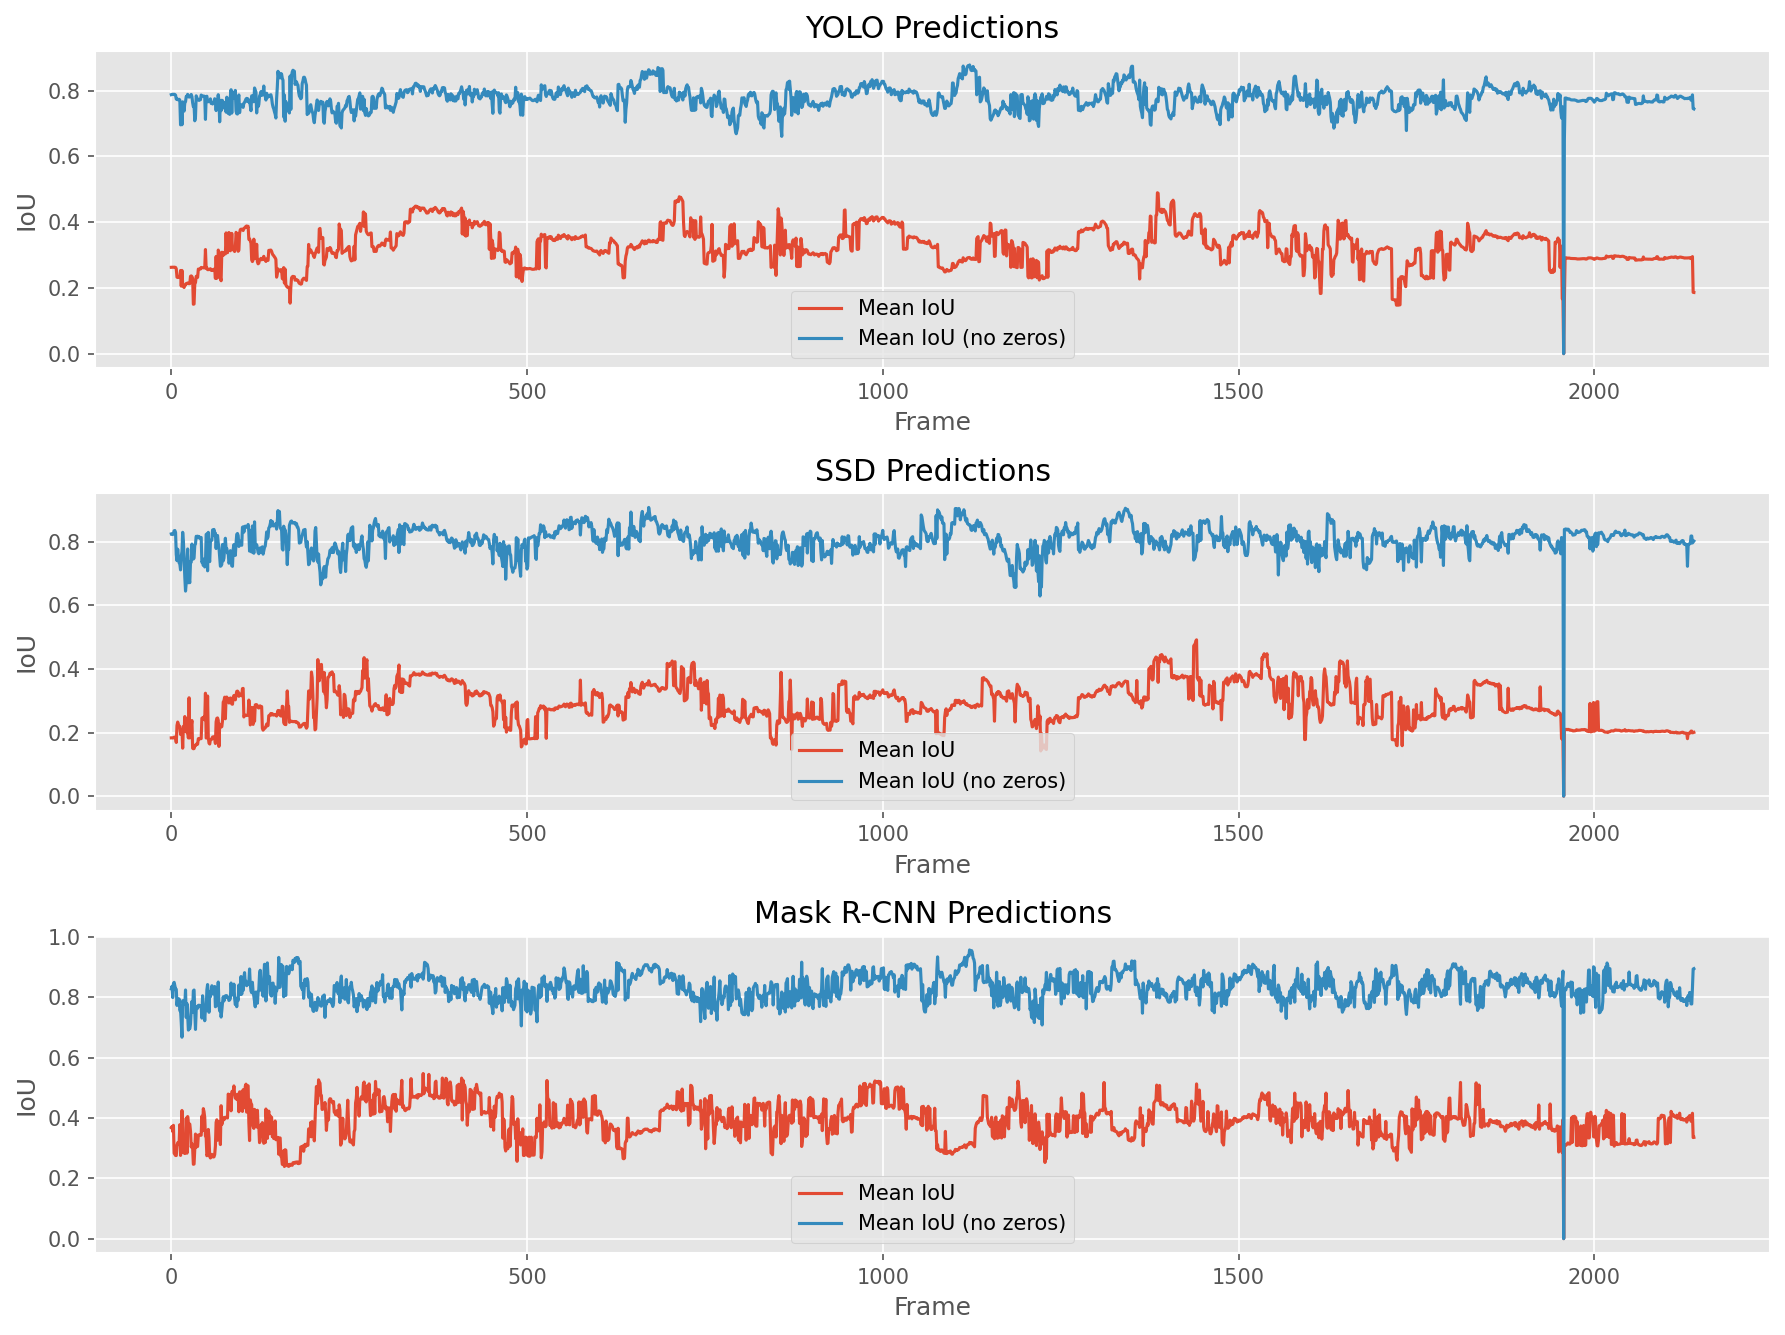

In [73]:
plt.style.use('ggplot')
plt.figure(dpi=150, figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.title("YOLO Predictions")
plt.plot(yolo_iou, label="Mean IoU")
plt.plot(yolo_iou_nz, label="Mean IoU (no zeros)")
plt.ylabel("IoU")
plt.xlabel("Frame")
plt.legend(loc="lower center")

plt.subplot(3, 1, 2)
plt.title("SSD Predictions")
plt.plot(ssd_iou, label="Mean IoU")
plt.plot(ssd_iou_nz, label="Mean IoU (no zeros)")
plt.ylabel("IoU")
plt.xlabel("Frame")
plt.legend(loc="lower center")

plt.subplot(3, 1, 3)
plt.title("Mask R-CNN Predictions")
plt.plot(mask_iou, label="Mean IoU")
plt.plot(mask_iou_nz, label="Mean IoU (no zeros)")
plt.ylabel("IoU")
plt.xlabel("Frame")
plt.legend(loc="lower center")

plt.tight_layout()
plt.savefig("./plot.png")
plt.show()
plt.close()

No explanation for this, really

In [75]:
np.where(yolo_iou_nz < 0.15)

(array([1957]),)

In [ ]:
from pathlib import Path

OUT_PATH = Path("/home/pau/Documents/master/M6/project/data/AICity_data/"
                "AICity_data/train/S03/c010")

YOLO_OUT_PATH = OUT_PATH / "vdo_gt_yolo"
YOLO_OUT_PATH.mkdir(parents=True, exist_ok=True)
SSD_OUT_PATH = OUT_PATH / "vdo_gt_ssd"
SSD_OUT_PATH.mkdir(parents=True, exist_ok=True)
MASK_OUT_PATH = OUT_PATH / "vdo_gt_mask"
MASK_OUT_PATH.mkdir(parents=True, exist_ok=True)

yolo_iou, yolo_iou_nz = iou_time(
    gt,
    det_yolo,
)
ssd_iou, ssd_iou_nz = iou_time(
    gt,
    det_ssd,
)
mask_iou, mask_iou_nz = iou_time(
    gt,
    det_rcnn,
)

plt.style.use('ggplot')
plt.figure(dpi=150, figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.title("YOLO Predictions")
plt.plot(yolo_iou, label="Mean IoU")
plt.plot(yolo_iou_nz, label="Mean IoU (no zeros)")
plt.ylabel("IoU")
plt.xlabel("Frame")
plt.legend(loc="lower center")

plt.subplot(3, 1, 2)
plt.title("SSD Predictions")
plt.plot(ssd_iou, label="Mean IoU")
plt.plot(ssd_iou_nz, label="Mean IoU (no zeros)")
plt.ylabel("IoU")
plt.xlabel("Frame")
plt.legend(loc="lower center")

plt.subplot(3, 1, 3)
plt.title("Mask R-CNN Predictions")
plt.plot(mask_iou, label="Mean IoU")
plt.plot(mask_iou_nz, label="Mean IoU (no zeros)")
plt.ylabel("IoU")
plt.xlabel("Frame")
plt.legend(loc="lower center")

plt.tight_layout()
plt.savefig("./plot.png")
plt.show()
plt.close()

In [96]:
def convert_txt_coco_annotation(txtpath: str):
    elms = []
    txtnot = load_annotations(txtpath)
    for frame, ID, left, top, width, height, confidence in np.asarray(txtnot):
        elms.append({
            "image_id": int(frame),
            "category_id": 1,
            "bbox": (
                int(left),
                int(top),
                int(width),
                int(height),
            ),
            "score": float(confidence),
        })
    return elms

In [97]:
import json

jpath = "/home/pau/Documents/master/M6/project/data/AICity_data/AICity_data/train/S03/c010/json_ann"
fpaths = [GT_FANCY_PATH, GT_PATH, DET_RCNN_PATH, DET_SSD_PATH, DET_YOLO_PATH]
fnames = ["gt_fancy", "gt", "det_rcnn", "det_ssd", "det_yolo"]

for path, name in zip(fpaths, fnames):
    jobj = convert_txt_coco_annotation(path)
    with open(jpath + f"/{name}.json", 'w') as f_js:
        json.dump(jobj, f_js)